In [ ]:
#default_exp models

In [1]:
import os 
os.chdir('/content/drive/My Drive/Semi Supervised Learning/Self-Supervised-Learning-fastai2')

In [2]:
!sh initialise.sh

     |████████████████████████████████| 184kB 10.4MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Found existing installation: fastcore 1.2.4
    Uninstalling fastcore-1.2.4:
      Successfully uninstalled fastcore-1.2.4


In [3]:
#export 
from ssl_fastai2.imports import *
from ssl_fastai2.utils import Encoding  

In [4]:
#export 
from torchvision.models.resnet import ResNet
from torchvision.models import resnet as resnet_module  
from torchvision.models.utils import load_state_dict_from_url 

In [5]:
#export  
arch_map = {'resnet18': {'block': resnet_module.BasicBlock, 'layers': [2, 2, 2, 2]},
            'resnet34': {'block': resnet_module.BasicBlock, 'layers': [3, 4, 6, 3]}, 
            'resnet50': {'block': resnet_module.Bottleneck, 'layers': [3, 4, 6, 3]}, 
            'resnet101': {'block': resnet_module.Bottleneck, 'layers': [3, 4, 23, 3]}, 
            'resnet152': {'block': resnet_module.Bottleneck, 'layers': [3, 8, 36, 3]}}

class CGDResNet(ResNet):
  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None): 
    super().__init__(block, layers, num_classes, zero_init_residual, groups, width_per_group, replace_stride_with_dilation, norm_layer) 
    self.inplanes = 128*block.expansion
    self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                   dilate = False)

def _rep_resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = CGDResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(resnet_module.model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict, strict = False)
    return model

In [6]:
#export 
def rep_resnet(arch, pretrained, progress = True, **kwargs):
  global arch_map  
  return _rep_resnet(arch, arch_map[arch]['block'], arch_map[arch]['layers'], pretrained = pretrained, progress = progress, **kwargs) 

In [7]:
#export 
class L2Norm(nn.Module):
  def forward(self, x):
    assert x.dim() == 2 , "Input Size should be [batch_size, represenation_dim]"
    return F.normalize(x, p = 2, dim = -1)

def lin_layer(in_feat, out_feat, bn = False, act_cls = nn.ReLU):
  linear = [nn.Linear(in_feat, out_feat)] 
  if bn:
    linear += [nn.BatchNorm1d(out_feat)]
    linear += [act_cls()]
  return nn.Sequential(*linear)

class BatchDropBlock(nn.Module):
  def __init__(self, h_ratio, w_ratio):
    super().__init__() 
    self.h_ratio = h_ratio 
    self.w_ratio = w_ratio 

  def forward(self, x):
    if self.training:
      h, w = x.size()[-2:]
      hr   = round(self.h_ratio*h )
      wr   = round(self.w_ratio*w )
      sx   = random.randint(0, h-hr)
      sy   = random.randint(0, w-wr)
      mask = x.new_ones(x.size())
      mask[:, :, sx:sx+hr, sy:sy+wr] = 0
      x = x*mask 
    return x

class RepresentationHead(nn.Module):
  def __init__(self, in_feat, rep_dim, 
               block_ratio = (0.3, 1.), bdb = True, 
               pool = nn.AdaptiveAvgPool2d(1), 
               lin_kwargs = {'bn':False, 'act_cls':nn.ReLU}, conv_kwargs = {'act_cls':nn.ReLU}, 
               use_conv_reduction = True): # Use ks 1 Conv2d to reduce from 2048 to 1024 dim if False use a lin_layer 
    
    super().__init__()
    self.use_bdb = bdb 
    self.bdb = BatchDropBlock(*block_ratio) 

    pool_layer = pool

    if use_conv_reduction: 
      conv_reduction = ConvLayer(2048, 1024, ks = 1, **conv_kwargs)
      lin_head = lin_layer(1024, rep_dim, **lin_kwargs)
      head = [conv_reduction, Flatten(), lin_head]
    else:
      head = [Flatten(), lin_layer(2048, rep_dim, **lin_kwargs)]

    regularisation = L2Norm()
    layers = [pool_layer, *head, regularisation]

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_bdb:
      x = self.bdb(x)
    return self.layers(x)

In [8]:
#export
def create_bottleneck(planes, use_bottleneck):
  try:
    grps = 2048//(planes*(1024//planes))
  except ZeroDivisionError:
    grps = 2

  if use_bottleneck or planes%2048 != 0:
    downsample = nn.Sequential(nn.Conv2d(planes, 2048, 1), nn.BatchNorm2d(2048))
    bottleneck = resnet_module.Bottleneck(planes, 512, groups = grps, downsample = downsample)
    return bottleneck 
  return None

In [9]:
#export 
class SSLModel(nn.Module):
  def __init__(self, encoder, global_rep = nn.Sequential(*[nn.AdaptiveAvgPool2d(1), Flatten()]), 
               use_bottleneck = True, heads = [],  
               global_head = None): 
    super().__init__()
    encoder_layers = [encoder]

    planes = Encoding(encoder, size = (224, 224)).final_channel
    bottleneck = create_bottleneck(planes, use_bottleneck)
    if bottleneck is not None:
      encoder_layers.append(bottleneck)

    self.encoder = nn.Sequential(*encoder_layers) 
    self.global_rep = global_rep

    if global_head:
      self.global_head = global_head 
      
    if len(heads) > 0:
      self.heads = nn.ModuleList(heads)

  def forward(self, x, glob = True):
    x = self.encoder(x)
    out = []
    # Global Branch
    if glob:
      out.append(self.global_rep(x))
      if hasattr(self, 'global_head'):
        out[0] = self.global_head(out[0])
    
    # Other Branches
    if hasattr(self, 'heads'): 
      features = []
      for head in self.heads:
        feat = head(x)
        features.append(feat)
      features = torch.cat(features, dim = 0)
      out.append(features)

    return out 

In [10]:
#export  
class ImageRepEncoder(nn.Module):
  def __init__(self, encoder, num_classes = None, use_bottleneck = True, custom_head = None):
    super().__init__()

    if not custom_head and not num_classes:
      raise ValueError('Provide number of clases needed for the classification head or provide a custom head')
      
    encoder_layers = [encoder]

    planes = Encoding(encoder, size = (224, 224)).final_channel 
    bottleneck = create_bottleneck(planes, use_bottleneck)
    if bottleneck is not None:
      encoder_layers.append(bottleneck)    

    self.encoder = nn.Sequential(*encoder_layers)
    if custom_head:
      self.head = custom_head
    else:
      self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(2048, num_classes))
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.head(x)
    return x 

In [11]:
#export 
class SIMClrHead(nn.Module):
  def __init__(self, rep_dim):
    super().__init__()
    self.lin1 = nn.Linear(2048, 1024)
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(1024, rep_dim)
    self.norm = L2Norm()
    
  def forward(self, x):
    return self.norm(self.lin2(self.relu(self.lin1(x))))

In [12]:
#export 
available_architectures = (arch_map.keys())
def cgd_encoder(arch:str, pretrained = True, **kwargs):
  if not isinstance(arch, str):
    raise ValueError('Pass the name of the architecture as the argument. eg resnet18')
  else:
    arch = arch.lower() 

  if not arch in available_architectures:
    raise NotImplementedError(f'This architecture is not yet implemented for CGD model.\n The available architectures are {available_architectures}')
    
  return create_body(partial(rep_resnet, arch = arch, pretrained = pretrained), **kwargs)

In [13]:
#export 
def SIMClrModel(encoder, rep_dim):
  return SSLModel(encoder, global_head = SIMClrHead(rep_dim),use_bottleneck = False)

In [14]:
#export 
class SPoC(nn.Module):
  def forward(self, x):
    return torch.sum(x, dim = [-2, -1]).view(x.shape[0], x.shape[1], 1, 1)

In [15]:
#export
class GeM(nn.Module):
  def __init__(self, p = 1., learnable = False):
    super().__init__()
    if learnable:
      self.p = nn.Parameter(torch.tensor([p]))
    else:
      self.p = p 

  def forward(self, x):
    return (x.pow(self.p).mean(dim = [-2, -1])).pow(1/self.p).view(x.shape[0], x.shape[1], 1, 1)

In [18]:
#export 
cgd_config = {'S': SPoC, 'G': GeM, 'M': nn.AdaptiveMaxPool2d}
def cgd_descriptors(rep_dim, types = ['S', 'G', 'M'], general_max_pool_learnable = False, 
                    general_max_pooling_p = 1., head_kwargs = {'use_conv_reduction':False, 'bdb':False}): 
  """
  'S' -> for Sum Pooling Convolution, 
  'G' -> for General Max Pooling, 
  'M' -> Max Pooling. 
  """
  descriptors = []
  for pool_type in types:
    if pool_type == 'G':
      pool = cgd_config[pool_type](general_max_pooling_p, general_max_pool_learnable)
    elif pool_type == 'M':
      pool = cgd_config[pool_type](1)
    else:
      pool = cgd_config[pool_type]()
    head = RepresentationHead(2048, rep_dim, pool = pool, **head_kwargs)
    descriptors.append(head) 
  return descriptors    

In [ ]:
GeM(learnable = True)(torch.rand((64, 2048, 14, 14))).shape

torch.Size([64, 2048, 1, 1])

In [ ]:
os.chdir('/content/')

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2020-10-21 06:21:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.9MB/s    in 18s     

2020-10-21 06:22:03 (13.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip tiny-imagenet-200.zip

In [ ]:
def get_labels(x):
  return x.parent.parent.name

tiny_imagenet_data = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                               get_items = get_image_files, 
                               splitter = RandomSplitter(0.1), 
                               getters = [lambda x:x, get_labels], 
                               item_tfms = [Resize(224)], 
                               batch_tfms =  aug_transforms() + [Normalize.from_stats(*imagenet_stats)]) 

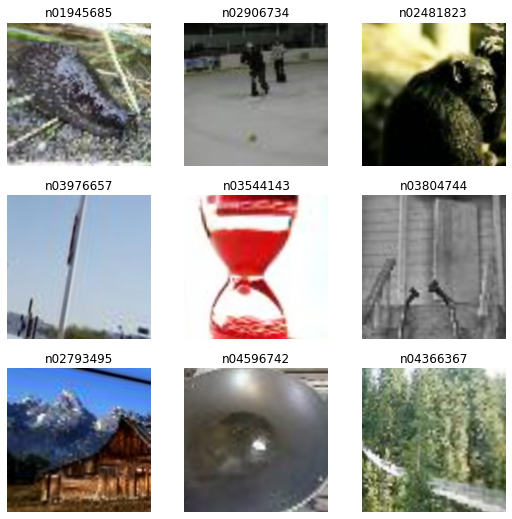

In [ ]:
path = Path('/content/tiny-imagenet-200/train')
dls = tiny_imagenet_data.dataloaders(path)
dls.show_batch()

In [ ]:
dls.vocab, dls.c

((#200) ['n01443537','n01629819','n01641577','n01644900','n01698640','n01742172','n01768244','n01770393','n01774384','n01774750'...],
 200)

In [ ]:
def image_rep_splitter(m):
  if len(m.encoder) == 2:
    return L([m.encoder[0], m.encoder[1], m.head]).map(params)
  else:
    return L([m.encoder, m.head]).map(params)
model = ImageRepEncoder(create_body(partial(rep_resnet, arch = 'resnet50')), dls.c, False)
learn = Learner(dls, model, splitter = image_rep_splitter, metrics = [accuracy, error_rate])
learn.freeze()

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=0.0691830962896347)

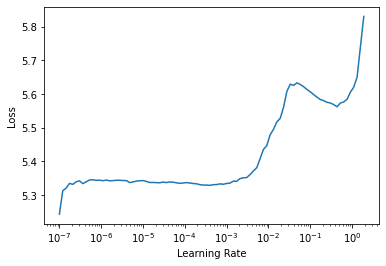

In [ ]:
learn.lr_find() 

In [ ]:
learn.fit_one_cycle(10, lr_max = slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.446212,4.316038,0.213900,0.786100,44:43
1,2.324895,2.086471,0.531700,0.468300,44:43
2,1.552973,1.404674,0.651700,0.348300,45:03
3,1.349123,1.217696,0.688600,0.311400,45:08
4,1.233612,1.116431,0.713000,0.287000,45:07
5,1.129943,1.067499,0.727300,0.272700,44:47
6,1.069395,1.028259,0.733900,0.266100,44:54


In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, lr_max = slice(3e-5, 1e-4))

In [ ]:
# from ssl_fastai2.utils import make_encoder
# rep_dim = 256
# # global_head = nn.Linear(256, 37)
# global_kwargs = {'lin_kwargs': {'bn':True}}
# heads = [RepresentationHead(2048, rep_dim, bdb = False, pool = nn.AdaptiveMaxPool2d(1)), 
#          RepresentationHead(2048, rep_dim, bdb = True, pool = nn.AdaptiveAvgPool2d(1))]
# model = SSLModel(create_body(partial(rep_resnet, arch = 'resnet34')), rep_dim, heads = heads, global_rep_kwargs = global_kwargs)#, global_head = global_head)
# model

In [ ]:
!sh nbdev_build.sh